In [1]:
name = '2017-06-30-pdf-scraping'
title = 'Extracting data from PDF files'
tags = 'pdf, text processing, pandas'
author = 'Denis Sergeev'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML, Image

html = connect_notebook_to_post(name, title, tags, author)

* Some organisations still release their data in PDF format
* PDF was not designed as a data format. It was designed as an "electronic paper" format.
* Main purpose: presenting elements exactly how creator want them to be, independent of operating system or time.
* PDF documents are not aware what tabular data, or even words are.
* Even when it's made using Microsoft Excel, the PDF document doesn't retain any sense of the "cells" that once contained the data.

**All these features make it very hard to extract text and especially tables from PDF documents**

One possible solution: store data as [attachments](http://blogs.adobe.com/insidepdf/2010/11/pdf-file-attachments.html).

Otherwise, you have to find a way to parse PDFs programmatically, especially if there are more than just a few of them.

Today we had a brief look at some of the most active/developed Python libraries that allow PDF text mining.

Below are the two PDF documents that will be used in this notebook:
1. [Sea Surface Temperature and Altimeter Synergy for Improved Forecasting of Polar Lows (STARS) manual](http://polarlow.met.no/documents/stars-dat_user-manual_p2d-4_v3p1.pdf)
1. [Moore, G. W. K., D. H. Bromwich, A. B. Wilson, I, Renfrew, and L. Bai, 2016: Arctic System Reanalysis improvements in topographically-forced winds near Greenland. Q. J. R. Meteorol. Soc., 142, 2033-2045, doi: 10.1002/qj.2798](http://polarmet.osu.edu/PMG_publications/moore_bromwich_qjrms_2016.pdf)

Let's define paths to these files

In [3]:
stars_file = '../pdfs/stars-dat_user-manual_p2d-4_v3p1.pdf'
moore2016_file = '../pdfs/moore_bromwich_qjrms_2016.pdf'

## [PDFMiner](https://github.com/euske/pdfminer)

> PDFMiner is a tool for extracting information from PDF documents. Unlike other PDF-related tools, it focuses entirely on getting and analyzing text data. PDFMiner allows one to obtain the exact location of text in a page, as well as other information such as fonts or lines.

This package is not extensively documented, but following [basic examples](https://euske.github.io/pdfminer/programming.html), you can start extracting useful information from a PDF file. 

### Simple example: extract table of contents

In [4]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument

Open the first PDF document in as a file stream in binary mode. Then we pass the file stream object to create a `PDFParser` instance and create a `PDFDocument` accordingly.

In [5]:
fp = open(stars_file, mode='rb')
parser = PDFParser(fp)
document = PDFDocument(parser)

Then, if a document has a built-in table of contents, we can extract it:

In [6]:
from pdfminer.pdfdocument import PDFNoOutlines

In [7]:
try:
    outlines = document.get_outlines()
except PDFNoOutlines:
    raise Exception('No outlines found!')

The result, `outlines`, is a generator object which contains section titles and their levels, as well as other technical info.

In [8]:
for i, (level, title, *_) in enumerate(outlines):
    if i < 10:
        # Print only first 10 lines
        print (level, title)

1 1. Introduction
2 1.1 Purpose of this document
2 1.2 Background
2 1.3 Structure of this documentation
2 1.4 Glossary
2 1.5 Reference Documents
1 2. STARS-DAT Data Model
2 2.1 Format
2 2.2 Organization
2 2.3 Content


In [9]:
fp.close()

### Another example

Another example of using `pdfminer` package is taken from [this gist](https://gist.github.com/jmcarp/7105045).

In [10]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter#process_pdf
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams

from io import StringIO

In [11]:
def pdf_to_text(pdfname, codec='utf-8'):
    """
    Extract text from a PDF document
    """
    # PDFMiner boilerplate
    rsrcmgr = PDFResourceManager()
    sio = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, sio, codec=codec, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)

    # Extract text
    with open(pdfname, mode='rb') as fp:
        for page in PDFPage.get_pages(fp):
            interpreter.process_page(page)

    # Get text from StringIO
    text = sio.getvalue()

    # Cleanup
    device.close()
    sio.close()

    return text

Let's apply it to the same PDF document:

In [12]:
mytext = pdf_to_text(stars_file)

And print only an excerpt from the file:

In [13]:
print(mytext[25000:26000])

duct is 
included in the sea ice files. More details about the sea ice concentration product are given in 
the OSI SAF Sea Ice Product Manual [RD-10]. The file name convention for these files are 
listed in Table 4.

5.6   Satellite radiometer imagery

The NOAA AVHRR satellite radiometer imagery data files in STARS-DAT are from the local 
receiving station at met.no. These files are only used for tracking polar low events. There is 
one file for each satellite passage, and the files are multi-layered TIFF files, one layer for 
each channel. The AVHRR data have two fixed visible channels (0.6 and 0.9 um) and two 
fixed infrared channels (10.5 and 11.5um). There is one “flexible” channel that depends from 
the different missions. This channel is either 1.6um or 3.7um, and for some satellites there is 
a switch between the two channels so that 1.6um is used at daytime and 3.7um at nighttime.

The file name convention for these files are listed in Table 4.

5.7   In situ data

The availabl

## [PDFPlumber](https://github.com/jsvine/pdfplumber)

A package that builds on `PDFMiner` and enables extraction of not only text, but tables and curves from a PDF document, is PDFPlumber. Thanks to [PythonBytes](https://pythonbytes.fm) podcast for letting me know about it.

In a nutshell,
<ul>
<li>Plumb a PDF for detailed information about each char, rectangle, line, etc - and easily extract text and tables.</li>
<li>Visual debugging with <code>.to_image()</code></li>
<li>Extracting tables
<ul>
<li>pdfplumber's approach to table detection borrows heavily from Anssi Nurminen's master's thesis, and is inspired by Tabula. It works like this:</li>
<li>For any given PDF page, find the lines that are (a) explicitly defined and/or (b) implied by the alignment of words on the page.</li>
<li>Merge overlapping, or nearly-overlapping, lines.</li>
<li>Find the intersections of all those lines.</li>
<li>Find the most granular set of rectangles (i.e., cells) that use these intersections as their vertices.</li>
<li>Group contiguous cells into tables.</li>
<li>Check out the demonstrations section.</li>
</ul></li>
</ul>

In [14]:
import pdfplumber

In [15]:
doc = pdfplumber.open(stars_file)  # No fussing about with binary file streams!

Select page nuber 36 from the document. It is a table containing polar low start and end locations and times.

In [16]:
p0 = doc.pages[35]

We can display it as image - very useful in Jupyter Notebook!

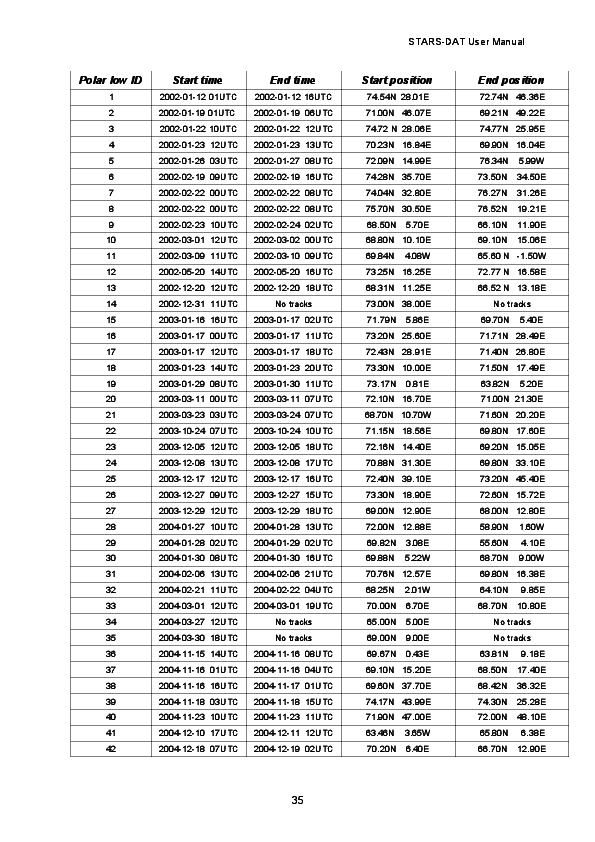

In [17]:
im = p0.to_image()
im

Another very useful tool is the visual debugger that shows what rows and columns are selected and if they are parsed correctly

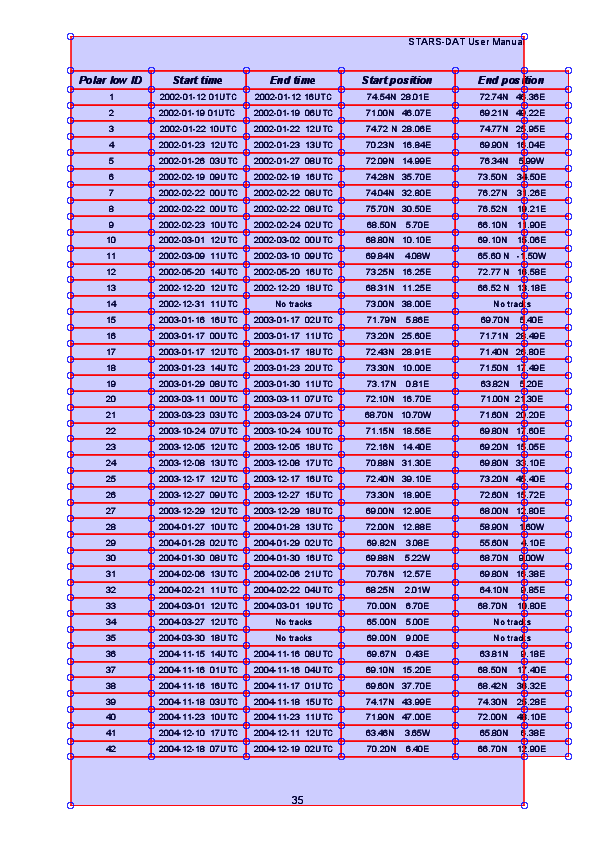

In [18]:
im.debug_tablefinder()

It can be seen that because there is some text before and after the table, the last column is split in half, following the text width.

One of the simplest (but not flexible) solutions is to crop the page before processing.

In [19]:
cropped = p0.crop((0, 50, p0.width, p0.height-100))

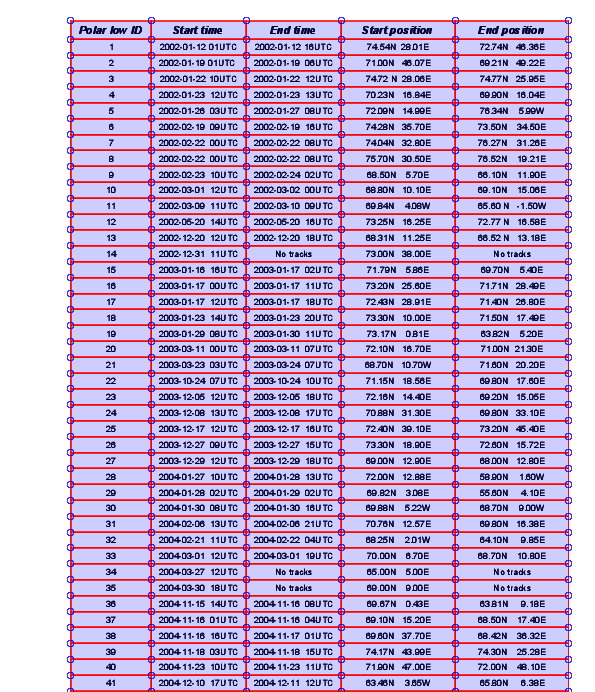

In [20]:
cropped.to_image().debug_tablefinder()

Now we only have the table itself, and all cells are separated correctly.

We don't even need to specify [`table_settings`](https://github.com/jsvine/pdfplumber#table-extraction-settings) to extract the table

In [21]:
table = cropped.extract_table()

The returned result is a list of lists containing rows of string data.

In [22]:
table[:3]  # the first three rows

[['Polar low ID', 'Start time', 'End time', 'Start position', 'End position'],
 ['1',
  '2002-01-12 01UTC',
  '2002-01-12 16UTC',
  '74.54N  28.01E',
  '72.74N   46.36E'],
 ['2',
  '2002-01-19 01UTC',
  '2002-01-19  06UTC',
  '71.00N   46.07E',
  '69.21N   49.22E']]

#### Converting to `DataFrame`

We can easily convert it to `pandas.Dataframe`. For the sake of brevity, we only convert the first 10 rows here.

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame(table[1:11], columns=table[0])

In [25]:
df

,Polar low ID,Start time,End time,Start position,End position
0,1,2002-01-12 01UTC,2002-01-12 16UTC,74.54N 28.01E,72.74N 46.36E
1,2,2002-01-19 01UTC,2002-01-19 06UTC,71.00N 46.07E,69.21N 49.22E
2,3,2002-01-22 10UTC,2002-01-22 12UTC,74.72 N 28.06E,74.77N 25.95E
3,4,2002-01-23 12UTC,2002-01-23 13UTC,70.23N 16.84E,69.90N 16.04E
4,5,2002-01-26 03UTC,2002-01-27 08UTC,72.09N 14.99E,76.34N 5.99W
5,6,2002-02-19 09UTC,2002-02-19 16UTC,74.28N 35.70E,73.50N 34.50E
6,7,2002-02-22 00UTC,2002-02-22 08UTC,74.04N 32.80E,76.27N 31.26E
7,8,2002-02-22 00UTC,2002-02-22 08UTC,75.70N 30.50E,76.52N 19.21E
8,9,2002-02-23 10UTC,2002-02-24 02UTC,68.50N 5.70E,66.10N 11.90E
9,10,2002-03-01 12UTC,2002-03-02 00UTC,68.80N 10.10E,69.10N 15.06E


We can also convert columns with strings representing dates and times to columns of datetime-like objects.

In [26]:
df[['Start time', 'End time']] = df[['Start time', 'End time']].apply(pd.to_datetime)

Since we already have an index ('Polar low ID'), we can reset it:

In [27]:
df.set_index('Polar low ID', inplace=True)

In [28]:
df

,Start time,End time,Start position,End position
Polar low ID,,,,
1,2002-01-12 01:00:00,2002-01-12 16:00:00,74.54N 28.01E,72.74N 46.36E
2,2002-01-19 01:00:00,2002-01-19 06:00:00,71.00N 46.07E,69.21N 49.22E
3,2002-01-22 10:00:00,2002-01-22 12:00:00,74.72 N 28.06E,74.77N 25.95E
4,2002-01-23 12:00:00,2002-01-23 13:00:00,70.23N 16.84E,69.90N 16.04E
5,2002-01-26 03:00:00,2002-01-27 08:00:00,72.09N 14.99E,76.34N 5.99W
6,2002-02-19 09:00:00,2002-02-19 16:00:00,74.28N 35.70E,73.50N 34.50E
7,2002-02-22 00:00:00,2002-02-22 08:00:00,74.04N 32.80E,76.27N 31.26E
8,2002-02-22 00:00:00,2002-02-22 08:00:00,75.70N 30.50E,76.52N 19.21E
9,2002-02-23 10:00:00,2002-02-24 02:00:00,68.50N 5.70E,66.10N 11.90E


We can also write a function to convert polar low positions (like "74.54N 28.01E") to numerical data.

In [29]:
def geostr2coord(arg):
    """
    Function to convert geographical coordinates in traditional notation to longitude and latitude
    
    [WIP]
    """
    pass

and then apply it to the relevant columns

In [30]:
for colname in ('Start position', 'End position'):
    df[colname] = df[colname].apply(geostr2coord)

## [Tabula-py](https://github.com/chezou/tabula-py)

Another promising library for PDF parsing is `tabula-py`, which is actually just Python bindings to a Java library with the same name.

So the caveat is that this is not a pure Python package, and you have to install Java to make it work.

Nevertheless, let's give it a try.

In [31]:
import tabula

Read data from the page 3 of the second PDF document.

In [32]:
doc = tabula.read_pdf(moore2016_file,
                      pages=3, multiple_tables=True)

In [33]:
doc[0]

,0,1,2,3,4,5,6
0,Site,ID,Vicinity,Data,Latitude,Longitude,Elevation (m)
1,Ittoqqortoormiit,04339,Scoresby Sund,"Surface, Upper-Air",70.48◦N,21.95◦W,65
2,Aputiteeq,04351,Kangerdlugssuaq Fjord,None,67.78◦N,32.30◦W,13
3,Tasiilaq,04360,Sermilik Fjord,"Surface, Upper-Air",65.60◦N,37.63◦W,36
4,Ikermiit,04373,Køge Bugt Fjord,Surface,64.78◦N,40.30◦W,85
5,Ikermiuarsuk,04382,North of Cape Farewell,Surface,61.93◦N,42.07◦W,39
6,Ikerasassuaq,04390,Cape Farewell,Surface,60.03◦N,43.12◦W,88
7,Narsarsuaq,04270,Cape Farewell,Upper-Air,61.15◦N,45.43◦W,65


As you can see, the package conveniently converts extracted tables to `pandas.DataFrame`. 

But what about the second table?

In [34]:
doc = tabula.read_pdf(moore2016_file,
                      pages=3, multiple_tables=True, area=(500, 0, 850, 500))

Even with `multiple_tables=True`, it could not extract two tables from the same page. Therefore, to get the second table (at the bottom of the page), we used a "dirty" solution again - we cropped half of the page.

In [35]:
doc[0]

,0,1,2,3,4,5,6
0,Flight,Date,Science aim,Area of operation,Take-off UTC,Landing UTC,Dropsondes
1,B268,21 February,Easterly tip jet,Cape Farewell,1048,1627,12
2,B271,25 February,Polar low interacting with Greenland,Iceland Sea,1035,1625,16
3,B274,2 March,Barrier winds,Denmark Strait,1107,1455,9
4,B276,5 March,Barrier winds,Denmark Strait,1120,1706,8
5,B277,6 March,Barrier winds,Denmark Strait,1027,1600,17
6,B278,9 March,Barrier winds and air–sea interaction,Denmark Strait,1031,1511,6


The tables still need a bit of cleaning, including the correct column names, of course.

## Some online converters

### PDFTables

https://pdftables.com/ - pay-per-page service focused on tabular data extraction from the folks at ScraperWiki

API: https://github.com/pdftables/python-pdftables-api

### PDF to XLS

http://pdftoxls.com/

## References

* https://pythonbytes.fm/episodes/show/26/how-have-you-automated-your-life-or-cli-with-python
* https://www.propublica.org/nerds/item/heart-of-nerd-darkness-why-dollars-for-docs-was-so-difficult

In [36]:
HTML(html)